In [62]:

import sys
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scipy as sp
import matplotlib.pyplot as plt
from dbn.tensorflow import SupervisedDBNClassification

ModuleNotFoundError: No module named 'dbn'

In [90]:
import graphviz 

In [91]:
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController


In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
from pybbn.generator.bbngenerator import convert_for_drawing
import matplotlib.pyplot as plt
import networkx as nx
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
wild_fires_colorado_data = pd.read_csv("2012_Colorado_wildfires-tweets_labeled.csv")
wild_fires_australia_data = pd.read_csv("2013_Australia_bushfire-tweets_labeled.csv")
wild_fires_data = [wild_fires_colorado_data , wild_fires_australia_data]
wild_fires_data = pd.concat(wild_fires_data)



In [66]:
wild_fires_data.head()

,Tweet ID,Tweet Text,Information Source,Information Type,Informativeness
0,211040709124440064,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,Not labeled,Not labeled,Not related
1,211111710294163457,RT @Jack4Ward: Get in on the fun every Thursda...,Not labeled,Not labeled,Not related
2,211157222699433985,Welcome to our newest STUDENTathlete- Reagan B...,Not labeled,Not labeled,Not related
3,211162553659830272,Denver Post: #Colorado governor signs bill cre...,Not labeled,Not labeled,Not related
4,211216962162933761,Pretty sure I'm going to live in Manitou Sprin...,Not labeled,Not labeled,Not related


In [67]:
columns = ["Tweet ID" , ' Information Source']
wild_fires_data.drop(columns, inplace=True, axis=1)


In [68]:
wild_fires_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2399 entries, 0 to 1198
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0    Tweet Text        2399 non-null   object
 1    Information Type  2399 non-null   object
 2    Informativeness   2399 non-null   object
dtypes: object(3)
memory usage: 75.0+ KB


In [69]:
wild_fires_data[' Informativeness'] = wild_fires_data[' Informativeness'].astype('category')

In [70]:
def Informativeness_to_numeric(x):
    if x=='Related and informative':
        return 3
    if x=='Not related':
        return 2
    if x=='Related - but not informative':
        return 1
    if x=='Not applicable':
        return 4

In [71]:
wild_fires_data[' Informativeness'] = wild_fires_data[' Informativeness'].apply(Informativeness_to_numeric)
wild_fires_data.head()


,Tweet Text,Information Type,Informativeness
0,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,Not labeled,2
1,RT @Jack4Ward: Get in on the fun every Thursda...,Not labeled,2
2,Welcome to our newest STUDENTathlete- Reagan B...,Not labeled,2
3,Denver Post: #Colorado governor signs bill cre...,Not labeled,2
4,Pretty sure I'm going to live in Manitou Sprin...,Not labeled,2


In [72]:
not_labelled = wild_fires_data[wild_fires_data[' Information Type'] == 'Not labeled']
not_labelled.head()

,Tweet Text,Information Type,Informativeness
0,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,Not labeled,2
1,RT @Jack4Ward: Get in on the fun every Thursda...,Not labeled,2
2,Welcome to our newest STUDENTathlete- Reagan B...,Not labeled,2
3,Denver Post: #Colorado governor signs bill cre...,Not labeled,2
4,Pretty sure I'm going to live in Manitou Sprin...,Not labeled,2


In [73]:
labelled = wild_fires_data[wild_fires_data[' Information Type'] != 'Not labeled']
labelled.head()


,Tweet Text,Information Type,Informativeness
14,RT @northfortynews: Tanker helicopter heads up...,Other Useful Information,3
16,#Evacuation center Cache La Poudre Middle Scho...,Caution and advice,3
19,20F degrees cooler tomorrow in North Central &...,Other Useful Information,3
21,FEMA has authorized the use of federal funds t...,Other Useful Information,3
22,#Media Large wildfire in N. Colorado prompts e...,Affected individuals,3


In [74]:
np.unique(labelled[' Information Type'])

array(['Affected individuals', 'Caution and advice',
       'Donations and volunteering', 'Infrastructure and utilities',
       'Not applicable', 'Other Useful Information',
       'Sympathy and support'], dtype=object)

In [75]:
def Information_Type_to_numeric(x):
    if x=='Affected individuals':
        return 3
    if x=='Caution and advice':
        return 2
    if x=='Donations and volunteering':
        return 1
    if x=='Infrastructure and utilities':
        return 4
    if x=='Not applicable':
        return 5
    if x=='Other Useful Information':
        return 6
    if x=='Sympathy and support':
        return 7

In [76]:
labelled[' Information Type'] = labelled[' Information Type'].apply(Information_Type_to_numeric)
labelled.head()

C:\Users\GUHAN\AppData\Local\Temp\ipykernel_20152\1238999291.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled[' Information Type'] = labelled[' Information Type'].apply(Information_Type_to_numeric)


,Tweet Text,Information Type,Informativeness
14,RT @northfortynews: Tanker helicopter heads up...,6,3
16,#Evacuation center Cache La Poudre Middle Scho...,2,3
19,20F degrees cooler tomorrow in North Central &...,6,3
21,FEMA has authorized the use of federal funds t...,6,3
22,#Media Large wildfire in N. Colorado prompts e...,3,3


In [77]:
labelled.shape

(1902, 3)

In [78]:
def nested_classify_nb(X_train, X_test, y_train, y_test, latent_train, latent_test):
    # fit two naive bayes models
    mnb1 = MultinomialNB()
    mnb1.fit(X_train, latent_train)
    cv_predicted = cross_val_predict(mnb1, X_train, latent_train, cv=LeaveOneOut())
    print ("Naive Bayes Training accuracy for Informativeness prediction: ", accuracy_score(latent_train, cv_predicted))
    
    
    mnb2 = MultinomialNB()
    mnb2.fit(X_train, y_train)
    cv_predicted = cross_val_predict(mnb2, X_train, y_train, cv=LeaveOneOut())
    print ("Naive Bayes Training accuracy for Information Type prediction: ", accuracy_score(y_train, cv_predicted))
    
    # predict class for first classifier
    pred1 = mnb1.predict(X_test)
    
    # extract indices where the predicted class is 3(related and informative)
    indices = np.where( pred1 == 3 )
    y_test_ri = y_test.iloc[indices]
    X_test_ri = X_test[indices]
    pred2 = []
    count = 0
    # predict class for second classifier only when the first predicted class is 3 
    for i in range(len(pred1)):
        if pred1[i] == 3:
            x_test = X_test_ri[count]
            pred2.append(mnb2.predict(x_test))
            count = count + 1
            print("Tweet ", i+1, " is informative with info type ", mnb2.predict(x_test))
        else:
            print("Tweet ", i+1, " is not informative!")
    
        
    print("Accuracy of the Classifier given the tweet is Informative is: ", accuracy_score(y_test_ri, pred2))
    print("Accuracy of the Classifier given the tweet is Informative is: ", accuracy_score(latent_test, pred1))


In [79]:
X = labelled.loc[:,' Tweet Text']
y = labelled.loc[:, ' Information Type']
latent = labelled.loc[:, ' Informativeness']

X_train, X_test, latent_train, latent_test = train_test_split(X, latent, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# count vectorizer to get bag of words from the tweets
cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

nested_classify_nb(X_train_cv, X_test_cv, y_train, y_test, latent_train, latent_test)


Naive Bayes Training accuracy for Informativeness prediction:  0.8183730715287517
Naive Bayes Training accuracy for Information Type prediction:  0.6423562412342216
Tweet  1  is informative with info type  [2]
Tweet  2  is not informative!
Tweet  3  is not informative!
Tweet  4  is informative with info type  [6]
Tweet  5  is informative with info type  [6]
Tweet  6  is informative with info type  [6]
Tweet  7  is informative with info type  [6]
Tweet  8  is informative with info type  [6]
Tweet  9  is informative with info type  [6]
Tweet  10  is not informative!
Tweet  11  is informative with info type  [6]
Tweet  12  is not informative!
Tweet  13  is informative with info type  [6]
Tweet  14  is informative with info type  [6]
Tweet  15  is informative with info type  [6]
Tweet  16  is informative with info type  [6]
Tweet  17  is informative with info type  [6]
Tweet  18  is informative with info type  [4]
Tweet  19  is not informative!
Tweet  20  is informative with info type  [6]

In [81]:
Info_Source = BbnNode(Variable(0,
                              'Info_Source',
                              ['Business', 'Eyewitness','Government', 'Media', 'NGOs', 'Outsiders']),
                              [0.01066, 0.069, 0.078, 0.48, 0.0511, 0.308])
Informativeness = BbnNode(Variable(1, 
                                  'Informativeness',
                                  ['Related_Informative', 'Related_Not_Informative']),
                                  [0.8, 0.2, 0.54, 0.46, 0.85, 0.15, 0.92, 0.08, 0.75, 0.25, 0.42, 0.58])
Info_Type = BbnNode(Variable(2,
                            'Info_Type', 
                            ['Affected Individuals', 'Caution', 'Donations', 'Infra', 'Other', 'Sympathy']), 
                            [0.18, 0.064, 0.089, 0.1, 0.52, 0.04, 0.089, 0.0038, 0.062, 0.0077, 0.26, 0.569])


In [87]:
bbn1 = Bbn() \
    .add_node(Info_Source) \
    .add_node(Informativeness) \
    .add_node(Info_Type) \
    .add_edge(Edge(Info_Source, Informativeness, EdgeType.DIRECTED)) \
    .add_edge(Edge(Informativeness, Info_Type, EdgeType.DIRECTED))

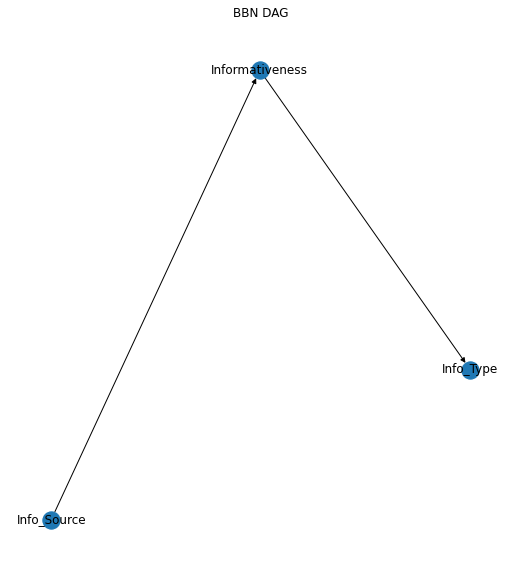

In [93]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    graph = convert_for_drawing(bbn1)
    pos = nx.nx_agraph.graphviz_layout(graph, prog='neato')

    plt.figure(figsize=(20, 10))
    plt.subplot(121) 
    labels = dict([(k, node.variable.name) for k, node in bbn1.nodes.items()])
    nx.draw(graph, pos=pos, with_labels=True, labels=labels)
    plt.title('BBN DAG')
    plt.savefig('DAG')